In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['keras-pretrain-model-weights', 'inceptionresnetv2', 'resnet50', 'imet-2019-fgvc6']


In [15]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
SIZE = 256
NUM_CLASSES = 1103
beta_f2=2
gamma = 2.0

In [16]:
# Load dataset info
path_to_train = '../input/imet-2019-fgvc6/train/'
data = pd.read_csv('../input/imet-2019-fgvc6/train.csv')

train_dataset_info = []
for name, labels in zip(data['id'], data['attribute_ids'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)

In [17]:
epsilon = K.epsilon()
def focal_loss(y_true, y_pred):
    pt = y_pred * y_true + (1-y_pred) * (1-y_true)
    pt = K.clip(pt, epsilon, 1-epsilon)
    CE = -K.log(pt)
    FL = K.pow(1-pt, gamma) * CE
    loss = K.sum(FL, axis=1)
    return loss

def f2(y_true, y_pred):
    assert y_true.shape[0] == y_pred.shape[0]

    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f2 = (1+beta_f2**2)*p*r / (p*beta_f2**2 + r + 1e-15)

    return f2

In [18]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

class data_generator(Sequence):
    
    def create_train(dataset_info, batch_size, shape, augument=True):
        assert shape[2] == 3
        while True:
            dataset_info = shuffle(dataset_info)
            for start in range(0, len(dataset_info), batch_size):
                end = min(start + batch_size, len(dataset_info))
                batch_images = []
                X_train_batch = dataset_info[start:end]
                batch_labels = np.zeros((len(X_train_batch), NUM_CLASSES))
                for i in range(len(X_train_batch)):
                    image = data_generator.load_image(
                        X_train_batch[i]['path'], shape)   
                    if augument:
                        image = data_generator.augment(image)
                    batch_images.append(image/255.)
                    batch_labels[i][X_train_batch[i]['labels']] = 1
                    
                yield np.array(batch_images, np.float32), batch_labels

    def create_valid(dataset_info, batch_size, shape, augument=False):
        assert shape[2] == 3
        while True:
            # dataset_info = shuffle(dataset_info)
            for start in range(0, len(dataset_info), batch_size):
                end = min(start + batch_size, len(dataset_info))
                batch_images = []
                X_train_batch = dataset_info[start:end]
                batch_labels = np.zeros((len(X_train_batch), NUM_CLASSES))
                for i in range(len(X_train_batch)):
                    image = data_generator.load_image(
                        X_train_batch[i]['path'], shape)   
                    if augument:
                        image = data_generator.augment(image)
                    batch_images.append(image/255.)
                    batch_labels[i][X_train_batch[i]['labels']] = 1
                yield np.array(batch_images, np.float32), batch_labels


    def load_image(path, shape):
        image = cv2.imread(path+'.png')
        image = cv2.resize(image, (SIZE, SIZE))
        return image

    def augment(image):
        augment_img = iaa.Sequential([
            sometimes(
            iaa.OneOf([
                # iaa.AddToHueAndSaturation((-20, 20)),
                iaa.Add((-10, 10), per_channel=0.5),
                iaa.Multiply((0.9, 1.1), per_channel=0.5),
                # iaa.GaussianBlur((0, 0.5)), # blur images with a sigma between 0 and 3.0
                iaa.ContrastNormalization((0.8, 1.2), per_channel=0.5), # improve or worsen the contrast
                iaa.Sharpen(alpha=(0, 0.2), lightness=(0.8, 1.2)), # sharpen images
                iaa.Emboss(alpha=(0, 0.5), strength=(0, 0.5)), # emboss images
                # iaa.Crop(percent=(0, 0.1))
                ])
            ),
            iaa.OneOf([
#                 iaa.Affine(rotate=0),
#                 iaa.Affine(rotate=90),
#                 iaa.Affine(rotate=180),
#                 iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                # iaa.Flipud(0.5),
            ])], random_order=True)

        image_aug = augment_img.augment_image(image)
        return image_aug

In [19]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,GlobalAveragePooling2D,
                          BatchNormalization, Input, Conv2D, Concatenate)
from keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
from keras.models import Model

In [20]:
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input


# pretrained model is of 3 channels
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = InceptionResNetV2(include_top=False,
                   weights=None,
                   input_tensor=input_tensor)
    base_model.load_weights('../input/inceptionresnetv2/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5')
    x = Conv2D(32, kernel_size=(1,1), activation='relu')(base_model.output)
    x = Flatten()(x)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='sigmoid', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

In [21]:
LR_MAX=1e-3
N_DATA_POINT=8000
EPOCHS=7
BATCH_SIZE=256

In [22]:
from keras.callbacks import Callback

def get_1cycle_schedule(lr_max=LR_MAX, n_data_points=N_DATA_POINT, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0):          
    if verbose > 0:
        print("Setting up 1Cycle LR schedule...")
    pct_start, div_factor = 0.3, 25.        # @sgugger's parameters in fastai code
    lr_start = lr_max/div_factor
    lr_end = lr_start/1e4
    n_iter = (n_data_points * epochs // batch_size) + 1    # number of iterations
    a1 = int(n_iter * pct_start)
    a2 = n_iter - a1

    # make look-up table
    lrs_first = np.linspace(lr_start, lr_max, a1)            # linear growth
    lrs_second = (lr_max-lr_end)*(1+np.cos(np.linspace(0,np.pi,a2)))/2 + lr_end  # cosine annealing
    lrs = np.concatenate((lrs_first, lrs_second))
    return lrs

class OneCycleScheduler(Callback):
    def __init__(self, **kwargs):
        super(OneCycleScheduler, self).__init__()
        self.verbose = kwargs.get('verbose', 0)
        self.lrs = get_1cycle_schedule(**kwargs)
        self.iteration = 0

    def on_batch_begin(self, batch, logs=None):
        lr = self.lrs[self.iteration]
        K.set_value(self.model.optimizer.lr, lr)         # here's where the assignment takes place
        if self.verbose > 0:
            print('\nIteration %06d: OneCycleScheduler setting learning '
                  'rate to %s.' % (self.iteration, lr))
        self.iteration += 1

    def on_epoch_end(self, epoch, logs=None):  # this is unchanged from Keras LearningRateScheduler
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)
        self.iteration = 0

In [23]:
# create callbacks list
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)
                             
from sklearn.model_selection import train_test_split

epochs = EPOCHS
batch_size = BATCH_SIZE

checkpoint = ModelCheckpoint('../working/Resnet50_focal.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, 
                                   verbose=1, mode='auto', epsilon=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=9)

csv_logger = CSVLogger(filename='../working/training_log.csv',
                       separator=',',
                       append=True)


# split data into train, valid
indexes = np.arange(train_dataset_info.shape[0])
train_indexes, valid_indexes = train_test_split(indexes, test_size=0.15, random_state=8)

# create train and valid datagens
train_generator = data_generator.create_train(
    train_dataset_info[train_indexes], batch_size, (SIZE,SIZE,3), augument=True)
train_generator_warmup = data_generator.create_train(
    train_dataset_info[train_indexes], batch_size, (SIZE,SIZE,3), augument=False)
validation_generator = data_generator.create_valid(
    train_dataset_info[valid_indexes], batch_size, (SIZE,SIZE,3), augument=False)


# lrsched = OneCycleScheduler(lr_max=1e-4, n_data_points=len(train_indexes),
#         epochs=1, batch_size=batch_size, verbose=0)
# callbacks_list = [checkpoint, csv_logger, lrsched]

In [24]:
# import torch.nn as nn
# import torch.nn.functional as F
# import torchvision.models

# class AttentionInceptionV3(nn.Module):
#     def __init__(self, num_classes=NUM_CLASSES, attention_size=8, aux_attention_size=8):
#         super().__init__()
#         self.num_classes = num_classes
#         self.cnn = torchvision.models.inception_v3(pretrained=True)
#         self.attention_size = attention_size
#         self.aux_attention_size = aux_attention_size

#         conv = self.cnn.Conv2d_1a_3x3.conv
#         self.cnn.Conv2d_1a_3x3.conv = nn.Conv2d(in_channels=4,
#                                                 out_channels=conv.out_channels,
#                                                 kernel_size=conv.kernel_size,
#                                                 stride=conv.stride,
#                                                 padding=conv.padding,
#                                                 bias=conv.bias)

#         # copy pretrained weights
#         self.cnn.Conv2d_1a_3x3.conv.weight.data[:,:3,:,:] = conv.weight.data
#         self.cnn.Conv2d_1a_3x3.conv.weight.data[:,3:,:,:] = conv.weight.data[:,:1,:,:]

#         self.features_a = nn.Sequential(
#             self.cnn.Conv2d_1a_3x3,
#             self.cnn.Conv2d_2a_3x3,
#             self.cnn.Conv2d_2b_3x3,
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             self.cnn.Conv2d_3b_1x1,
#             self.cnn.Conv2d_4a_3x3,
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             self.cnn.Mixed_5b,
#             self.cnn.Mixed_5c,
#             self.cnn.Mixed_5d,
#             self.cnn.Mixed_6a,
#             self.cnn.Mixed_6b,
#             self.cnn.Mixed_6c,
#             self.cnn.Mixed_6d,
#             self.cnn.Mixed_6e,
#         )

#         self.features_b = nn.Sequential(
#             self.cnn.Mixed_7a,
#             self.cnn.Mixed_7b,
#             self.cnn.Mixed_7c,
#         )

#         self.aux_avgpool = nn.AdaptiveAvgPool2d(self.aux_attention_size)
#         aux_in_features = self.cnn.AuxLogits.fc.in_features
#         self.aux_linear = nn.Conv2d(aux_in_features, self.num_classes, kernel_size=1, padding=0)
#         self.aux_attention = nn.Conv2d(aux_in_features, self.num_classes, kernel_size=1, padding=0)

#         self.avgpool = nn.AdaptiveAvgPool2d(self.attention_size)
#         in_features = self.cnn.fc.in_features
#         self.last_linear = nn.Conv2d(in_features, self.num_classes, kernel_size=1, padding=0)
#         self.attention = nn.Conv2d(in_features, self.num_classes, kernel_size=1, padding=0)

#     def forward(self, x):
#         features_a = self.features_a(x)
#         if self.training:
#             if self.aux_attention_size != features_a.size(-1):
#                 aux_features = self.aux_avgpool(features_a)
#             else:
#                 aux_features = features_a
#             aux_logits = self.aux_linear(aux_features)
#             assert aux_logits.size(1) == self.num_classes and \
#                    aux_logits.size(2) == self.aux_attention_size and \
#                    aux_logits.size(3) == self.aux_attention_size
#             aux_logits_attention = self.aux_attention(aux_features)
#             assert aux_logits_attention.size(1) == self.num_classes and \
#                    aux_logits_attention.size(2) == self.aux_attention_size and \
#                    aux_logits_attention.size(3) == self.aux_attention_size
#             aux_logits_attention = aux_logits_attention.view(
#                 -1, self.num_classes,
#                 self.aux_attention_size * self.aux_attention_size)
#             aux_attention = F.softmax(aux_logits_attention, dim=2)
#             aux_attention = aux_attention.view(
#                 -1, self.num_classes, self.aux_attention_size, self.aux_attention_size)
#             aux_logits = aux_logits * aux_attention
#             aux_logits = aux_logits.view(
#                 -1, self.num_classes,
#                 self.aux_attention_size * self.aux_attention_size).sum(2).view(-1, self.num_classes)

#         features_b = self.features_b(features_a)
#         if self.aux_attention_size != features_b.size(-1):
#             features_b = self.avgpool(features_b)
#         logits = self.last_linear(features_b)
#         assert logits.size(1) == self.num_classes and \
#                logits.size(2) == self.attention_size and \
#                logits.size(3) == self.attention_size

#         logits_attention = self.attention(features_b)
#         assert logits_attention.size(1) == self.num_classes and \
#                logits_attention.size(2) == self.attention_size and \
#                logits_attention.size(3) == self.attention_size
#         logits_attention = logits_attention.view(-1, self.num_classes, self.attention_size * self.attention_size)
#         attention = F.softmax(logits_attention, dim=2)
#         attention = attention.view(-1, self.num_classes, self.attention_size, self.attention_size)

#         logits = logits * attention
#         logits = logits.view(-1, self.num_classes, self.attention_size * self.attention_size).sum(2).view(-1, self.num_classes)
#         if self.training:
#             return logits, aux_logits
#         return logits


# def get_attention_inceptionv3(num_classes=NUM_CLASSES, **kwargs):
#     return AttentionInceptionV3(num_classes=num_classes, **kwargs)

In [25]:
# model = get_attention_inceptionv3()

In [26]:
# warm up model
model = create_model(
    input_shape=(SIZE,SIZE,3), 
    n_out=NUM_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5,0):
    model.layers[i].trainable = True

# model.compile(
#     loss=focal_loss,
#     optimizer=Adam(lr=1e-4))

# # model.summary()

# model.fit_generator(
#     train_generator_warmup,
#     steps_per_epoch=np.ceil(float(len(train_indexes)) / float(batch_size)),
#     epochs=epochs,
#     max_queue_size=16, workers=WORKERS, use_multiprocessing=True,
#     verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [27]:
# train all layers
# for layer in model.layers:
#     layer.trainable = True

model.compile(loss=focal_loss,
            optimizer=Adam(LR_MAX))

model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(float(len(train_indexes)) / float(batch_size)),
    validation_data=validation_generator,
    validation_steps=np.ceil(float(len(valid_indexes)) / float(batch_size)),
    epochs=EPOCHS,
    max_queue_size=16, workers=WORKERS, use_multiprocessing=True,
    verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/7
363/363 [==============================] - 1027s 3s/step - loss: 7.9416 - val_loss: 5.2257
Epoch 2/7
363/363 [==============================] - 990s 3s/step - loss: 4.4782 - val_loss: 4.6906
Epoch 3/7
363/363 [==============================] - 979s 3s/step - loss: 4.1791 - val_loss: 4.3519
Epoch 4/7
363/363 [==============================] - 984s 3s/step - loss: 4.0963 - val_loss: 4.1187
Epoch 5/7
363/363 [==============================] - 976s 3s/step - loss: 3.9954 - val_loss: 4.1896
Epoch 6/7
363/363 [==============================] - 990s 3s/step - loss: 3.9830 - val_loss: 3.9815
Epoch 7/7
363/363 [==============================] - 976s 3s/step - loss: 3.9110 - val_loss: 3.9736


In [28]:
fullValGen = data_generator.create_valid(
    train_dataset_info[valid_indexes], BATCH_SIZE, (SIZE,SIZE,3))

n_val = round(train_dataset_info.shape[0]*0.15)//BATCH_SIZE
print(n_val)

lastFullValPred = np.empty((0, NUM_CLASSES))
lastFullValLabels = np.empty((0, NUM_CLASSES))
for i in tqdm(range(n_val+1)): 
    im, lbl = next(fullValGen)
    scores = model.predict(im)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
print(lastFullValPred.shape, lastFullValLabels.shape)

  0%|          | 0/65 [00:00<?, ?it/s]

64


100%|██████████| 65/65 [03:44<00:00,  2.41s/it]

(16386, 1103) (16386, 1103)


100%|██████████| 50/50 [00:18<00:00,  2.63it/s]


thr=0.280 F2=0.363


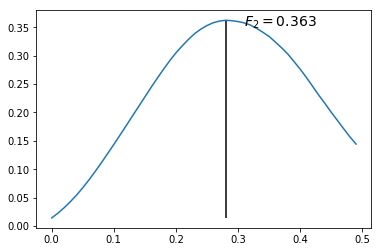

In [29]:
def find_best_fixed_threshold(preds, targs, do_plot=True):
    score = []
    thrs = np.arange(0, 0.5, 0.01)
    for thr in tqdm(thrs):
        score.append(f2(targs, (preds > thr).astype(int) ))
    score = np.array(score)
    pm = score.argmax()
    best_thr, best_score = thrs[pm], score[pm].item()
    print(f'thr={best_thr:.3f}', f'F2={best_score:.3f}')
    if do_plot:
        plt.plot(thrs, score)
        plt.vlines(x=best_thr, ymin=score.min(), ymax=score.max())
        plt.text(best_thr+0.03, best_score-0.01, f'$F_{2}=${best_score:.3f}', fontsize=14);
        plt.show()
    return best_thr, best_score

best_thr, best_score = find_best_fixed_threshold(lastFullValPred, lastFullValLabels, do_plot=True)

In [30]:
# model.save("resnet-50_version1.h5")